# Homework 3: ***Probabilistic Programming*** and ***Probabilistic Graphical Models***

Probabilistic Machine Learning -- Spring 2023, UniTS

Before starting, a read of [the recap notebook on ***Probabilistic Graphical Models***](https://github.com/emaballarin/probml-units/blob/main/notebooks/04_graphical_models.ipynb) is strongly recommended!  
Notebooks [\#1](https://github.com/emaballarin/probml-units/blob/main/notebooks/03a_probabilistic_programming.ipynb) and [\#2](https://github.com/emaballarin/probml-units/blob/main/notebooks/03b_probabilistic_programming.ipynb) about ***Probabilistic Programming*** and inference in `Pyro` may also be useful for the practical part.

### Exercise 1 (theory: *Bayesian Networks*)

1. Draw the *Bayesian Network* representation of the joint distribution:

$$P(A,B,C,D,E,F,G)=P(A)P(B|A)P(F|B)P(C|A)P(D|B)P(E|D,F)P(G).$$

2. Indicate whether the following statements on (conditional) independence are `True` or `False` in such joint distribution, and motivate your answer.

    (a.) ${~}$ ${~}$ $A\perp \!\!\! \perp D$  
    (b.) ${~}$ ${~}$ $F\perp \!\!\! \perp D$  
    (c.) ${~}$ ${~}$ $A\perp \!\!\! \perp B\ |\ C$  
    (d.) ${~}$ ${~}$ $A\perp \!\!\! \perp D\ |\ B$  
    (e.) ${~}$ ${~}$ $D\perp \!\!\! \perp F\ |\ E$  
    (f.) ${~}$ ${~}$ $B\perp \!\!\! \perp F\ |\ E$  
    (g.) ${~}$ ${~}$ $A\perp \!\!\! \perp D\ |\ \{B, F\}$  

#### Solution

##### 1.

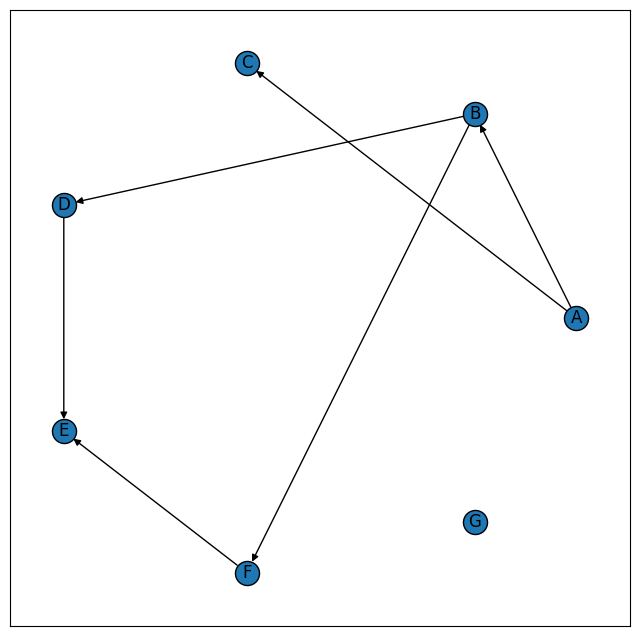

In [151]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph(directed=True)

G.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G'])

G.add_edges_from([('A', 'B'), ('A', 'C'), ('B', 'D'), ('B', 'F'), ('D', 'E'), ('F', 'E')])

plt.figure(figsize=(8, 8))

pos = nx.circular_layout(G)

nx.draw_networkx(G, pos=pos, with_labels = True, arrows=True)

ax = plt.gca()
ax.collections[0].set_edgecolor("#000000")

##### 2.

(a.) False, because D depends on B which depends on A:
$$
P(A,D) = \sum_B \left[P(D|B)P(B|A)\right]P(A) \neq P(A)P(D)
$$

(b.) False, in fact:
$$
P(F,D) = \sum_B P(F|B)P(D|B)P(B) \neq P(F)P(D)
$$

(c.) False, in fact we have:
$$
P(A,B|C) = \frac{P(A,B,C)}{P(C)} = \frac{P(B|A)P(C|A)P(A)}{P(C)} = P(B|A)P(A|C) \neq P(A|C)P(B|C)
$$

(d.) True, in fact:
$$
P(A,D|B) = \frac{P(A,D,B)}{P(B)} = \frac{P(D|B)P(B|A)P(A)}{P(B)} = P(D|B)P(A|B)
$$

(e.) False, in fact:
$$
P(D,F|E) = \frac{P(E|D,F)P(D,F)}{P(E)} \neq P(D|E)P(F|E)
$$

(f.) False, in fact:
$$
P(B,F|E) = \frac{P(B,F,E)}{P(E)} = \frac{P(E|F)P(F|B)P(B)}{P(E)} = \frac{P(F|E)P(F|B)P(B)}{P(F)} = P(F|E)P(B|F) \neq P(B|E)P(F|E)
$$

(g.) True, in fact:
$$
P(A,D|B,F) = \frac{P(A,D,B,F)}{P(B,F)} = \frac{P(F|B)P(D|B)P(B|A)P(A)}{P(F|B)P(B)} = P(D|B)P(A|B),
$$
but also:
$$
P(A|B,F)P(D|B,F) = \frac{P(A,B,F)P(D,B,F)}{P(B,F)^2} = \frac{P(F|B)P(B|A)P(A)P(D|B)P(F|B)P(B)}{P(F|B)^2P(B)^2} = P(D|B)P(A|B)
$$

### Exercise 2 (practicum: *Probabilistic Graphical Models* in `Pyro`)

1. Write the generative model represented by the following directed graph
where:  
    i.  )  $p$ and $\pi_j$ are sampled from Beta distributions;  
    ii. )  $r_i$ is sampled from a Bernoulli distribution;  
    iii.)  $u_{ij}$ is sampled from a Bernoulli distribution with parameter $r_i (1 - \pi_j) + (1 - r_i)\pi_j$.  

1. Implement the same generative model in `Pyro`.  
Set the hyperparameters to $\alpha_p=1,\ \ \beta_p=1,\ \ \alpha_\pi=1,\ \ \beta_\pi=5$ and evaluate your model on synthetic observations obtained as `data = pyro.distributions.Bernoulli(0.6).sample((12,6))`.  
Remember to use the *plate notation* adequately and to condition on observed data!  
If you need to jointly *plate* *w.r.t.* different variables, you can use `pyro.plate` context managers as follows:

    ```python
    plate_1 = pyro.plate(...)
    plate_2 = pyro.plate(...)

    with plate_1:
        # do something while plating on plate_1 only
    
    with plate_2:
        # do something while plating on plate_2 only

    with plate_1, plate_2:
        # do something while jointly-plating

#### Solution

##### 1.

1. $p \sim Beta(\alpha_p, \beta_p)$
2. $\pi_j \sim Beta(\alpha_{\pi}, \beta_{\pi})$, for $j=1,...,N$
3. $r_i|p \sim Bern(p)$, for $i=1,...,S$
4. $u_{ij}|r_i,\pi_j \sim Bern(r_i(1-\pi_j)+(1-r_i)\pi_j)$, for $i=1,...,S, j=1,...,N$

##### 2.

In [152]:
import pyro
import pyro.distributions as dist

# setting parameters
alpha_p = 1
beta_p = 1
alpha_pi = 1
beta_pi = 5

def model(data):

    # sampling p
    p = pyro.sample("p", dist.Beta(alpha_p, beta_p))

    plate_left = pyro.plate("left", data.shape[0], dim=-2)
    plate_right = pyro.plate("right", data.shape[1], dim=-1)

    # plating for r
    with plate_left:
        r = pyro.sample("r", dist.Bernoulli(p))

    # plating for pi
    with plate_right:
        pi = pyro.sample("pi", dist.Beta(alpha_pi, beta_pi))

    # plating for u
    with plate_left, plate_right:
        u = pyro.sample("u", dist.Bernoulli(r*(1-pi)+(1-r)*pi),
                        obs=data)

    print(f"p = {p}\nr = {r}\npi = {pi}\nu = {u}")

In [153]:
data = dist.Bernoulli(0.6).sample((12,6))

In [154]:
display(data)

tensor([[1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0., 1.],
        [1., 1., 0., 1., 1., 0.],
        [1., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 1., 0.],
        [1., 0., 0., 1., 0., 1.],
        [1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1.],
        [1., 0., 1., 0., 0., 1.],
        [1., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1.]])

In [155]:
model(data)

p = 0.6176608204841614
r = tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.]])
pi = tensor([0.1338, 0.1111, 0.3461, 0.2215, 0.1465, 0.0205])
u = tensor([[1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0., 1.],
        [1., 1., 0., 1., 1., 0.],
        [1., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 1., 0.],
        [1., 0., 0., 1., 0., 1.],
        [1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1.],
        [1., 0., 1., 0., 0., 1.],
        [1., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1.]])


### Exercise 3 (practicum: *Gaussian Process Classification* in `Pyro`)

Consider an instance of the *Half Moons* dataset, a *toy* dataset for classification featuring two interleaving noisy half-annuli. For the sake of simplicity, it has been already be generated, plotted, and converted to `PyTorch` tensors for you:

In [156]:
import numpy as np

import torch as th

import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
import seaborn as sns

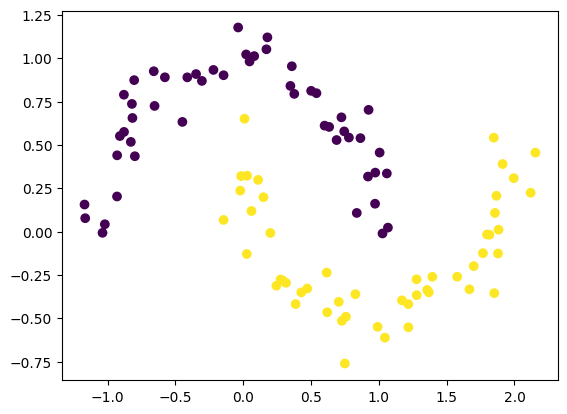

In [157]:
x, y = make_moons(n_samples=100, shuffle=True, noise=0.1, random_state=1)
_ = plt.scatter(x[:, 0], x[:, 1], c=y)

In [158]:
x, y = th.from_numpy(x).float(), th.from_numpy(y).float()

Consider the following generative model:

$$
\begin{align*}
    (y_n \ |\  p_n) &\sim \mathrm{Bern}(p_n) \quad \text{for } n=1,\ldots,N\\
    (\mathrm{logit}(\boldsymbol{p})\ |\ \mu,\sigma,l) &\sim \mathcal{GP}(\mu, K_{\sigma,\  l}(x_n))\\
    \mu &\sim \mathcal{N}(0,1)\\
    \sigma &\sim \mathrm{LogNormal}(0,1)\\
    l &\sim \mathrm{LogNormal}(0,1)
\end{align*}
$$

where we model:
- the binary response variable with a Bernoullian likelihood;
- the logit of the joint probability $\boldsymbol{p} = (p_1, \dots, p_n, \dots, p_N)$ with a Gaussian Process having
    - predictors $x_n$,
    - mean $\mu$: harvested from a standard normal distribution,
    - kernel matrix $K_{\sigma, l}$, parameterized by:
        - variance $\sigma$ and lengthscale $l$: : harvested from two *i.i.d.* standard log-normal distributions.

We want to solve this binary classification problem by means of *Hamiltonian Monte Carlo* inference: this requires a reparametrization of the multivariate Gaussian $\mathcal{GP}(\mu, K_{\sigma,\  l}(x_n))$ for the sake computational efficiency.  

Specifically, we will model logit probability as:

$$\mathrm{logit}(\boldsymbol{p}) = \mu \cdot \mathbf{1}_N + \eta \cdot L,$$

where:
- $L$ is the *Cholesky factor* of $K_{\sigma,\  l}$
- $\eta_n\sim\mathcal{N}(0,1)$.

This relationship is implemented by the `get_logits` function below:


In [159]:
def get_logits(x, mu, sigma, l, eta):
    kernel = gp.kernels.RBF(
        input_dim=2,
        variance=(sigma if isinstance(sigma, th.Tensor) else th.tensor(sigma)),
        lengthscale=(l if isinstance(l, th.Tensor) else th.tensor(l)),
    )
    K = kernel.forward(x, x) + th.eye(x.shape[0]) * 1e-4
    L = th.linalg.cholesky(K)
    return mu + th.mv(L, eta)

Write a pyro model `gp_classifier(x, y, logit_function)` that implements the reparametrized generative model, using `get_logits` function. Remember to `plate` on independent observations!

In [160]:
def gp_classifier(x, y, logit_function):

    N = len(y)

    # setting parameters
    mu_par = 0
    var_par = 1

    # sampling simgle parameters
    mu = pyro.sample("mu", dist.Normal(mu_par, var_par))
    sigma = pyro.sample("sigma", dist.LogNormal(mu_par, var_par))
    l = pyro.sample("l", dist.LogNormal(mu_par, var_par))

    # plating for eta
    with pyro.plate("eta_plate", N):
        eta = pyro.sample("eta", dist.Normal(mu_par, var_par))

    # getting p
    logit_p = logit_function(x, mu, sigma, l, eta)

    # plating for y
    with pyro.plate("y_plate", N):
        y = pyro.sample("y", dist.Bernoulli(logits=logit_p), obs=y)

By using `pyro.NUTS` on the `gp_classifier` model, we can infer the posterior distribution of its parameters via the *No U-Turn Sampler*, an effective *HMC* method.  Posterior samples can be extracted using the `.get_samples()` method.

In [161]:
nuts_kernel = NUTS(gp_classifier)
mcmc = MCMC(nuts_kernel, warmup_steps=50, num_samples=10)
posterior = mcmc.run(x=x, y=y, logit_function=get_logits)
mcmc.summary()

Sample: 100%|██████████| 60/60 [05:37,  5.63s/it, step size=1.99e-02, acc. prob=0.146]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]      1.40      0.13      1.41      1.21      1.53      6.00      1.03
    eta[1]      1.17      0.46      1.00      0.78      2.06      3.81      1.51
    eta[2]     -1.41      0.42     -1.33     -2.15     -1.03      2.83      1.95
    eta[3]     -0.51      0.15     -0.50     -0.78     -0.31      6.40      1.13
    eta[4]      1.57      0.34      1.33      1.26      2.08      3.06      1.55
    eta[5]     -1.33      0.19     -1.37     -1.61     -1.05      2.78      2.23
    eta[6]     -0.21      0.09     -0.23     -0.36     -0.01      9.61      0.94
    eta[7]     -0.63      0.10     -0.67     -0.82     -0.49      3.33      2.57
    eta[8]      1.66      0.25      1.72      1.17      1.84      5.20      0.99
    eta[9]      1.80      0.20      1.75      1.45      2.10      5.87      0.92
   eta[10]      0.11      0.11      0.16     -0.08      0.21      3.65      1.64
   eta[11]     -0.66      0

In [162]:
mcmc_samples = mcmc.get_samples()

The `posterior_predictive` function shown below outputs the prediction corresponding to the $i$-th sample from the posterior.

In [163]:
def posterior_predictive(samples, i, x, x_grid):
    x, x_grid = x.float(), x_grid.float()

    kernel = gp.kernels.RBF(
        input_dim=2, variance=samples["sigma"][i], lengthscale=samples["l"][i]
    )
    n_grid = x_grid.shape[0]

    y = get_logits(
        x, samples["mu"][i], samples["sigma"][i], samples["l"][i], samples["eta"][i]
    )

    with th.no_grad():
        gpr = gp.models.GPRegression(x, y, kernel=kernel)
        mean, cov = gpr(x_grid, full_cov=True)

        mean, cov = mean.float(), cov.float()

    yhat = dist.MultivariateNormal(mean, cov + th.eye(n_grid) * 100 * 1e-4).sample()
    return yhat.sigmoid().numpy()

The `plot_pyro_predictions` function below calls `posterior_predictive` to compute the average prediction on each input point and plots the posterior predictive mean function over a finite grid of points.

In [164]:
def scatterplot(x, y):
    colors = np.array(["0", "1"])
    sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=colors[y.int()])


def meshgrid(x, n, eps=0.1):
    x0, x1 = np.meshgrid(
        np.linspace(x[:, 0].min() - eps, x[:, 0].max() + eps, n),
        np.linspace(x[:, 1].min() - eps, x[:, 1].max() + eps, n),
    )
    x_grid = np.stack([x0.ravel(), x1.ravel()], axis=-1)
    return x0, x1, x_grid


def plot_pyro_predictions(posterior_samples, x, y):
    n_samples = posterior_samples["sigma"].shape[0]
    x0, x1, x_grid = meshgrid(x, 30)
    x_grid = th.from_numpy(x_grid)
    preds = np.stack(
        [
            posterior_predictive(posterior_samples, i, x, x_grid)
            for i in range(n_samples)
        ]
    )

    plt.figure(figsize=np.array([10, 6]))
    plt.contourf(
        x0,
        x1,
        preds.mean(0).reshape(x0.shape),
        101,
        vmin=0,
        vmax=1,
    )

    plt.title("Posterior Mean")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    scatterplot(x, y)

Plot the posterior predictive mean function over a finite grid of points, together with the training data. Comment on the results.

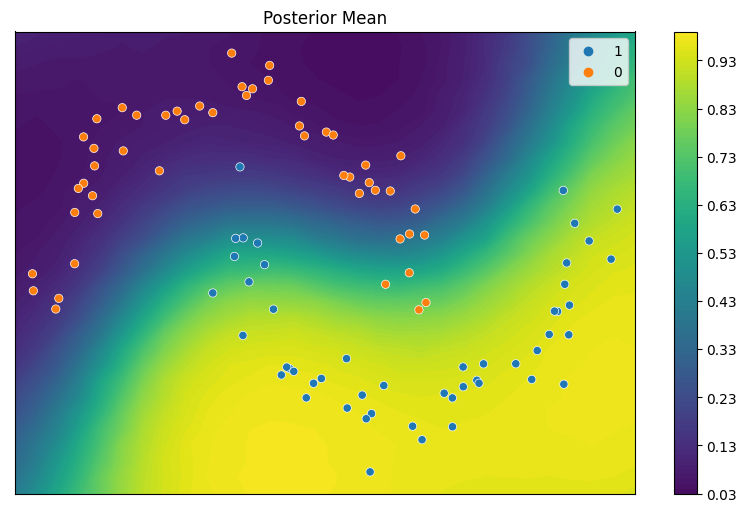

In [165]:
plot_pyro_predictions(mcmc_samples, x, y)

As we cas see from the plot, the Gaussian process-based model is able to capture pretty well the non linearity of the system. In other words, the model is flexible enough to handle the peculiar distribution of data points, with the right uncertainty in the "middle region".